<a href="https://colab.research.google.com/github/Dolewma/retail_demand_forecast/blob/main/course_project_week_2_and_3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# TensorFlow for LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Load and prepare data
raw_df = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/df_prepared_guayas.csv')
raw_df = raw_df[(raw_df['date'] >= '2014-01-01') & (raw_df['date'] < '2014-04-01')]
raw_df['date'] = pd.to_datetime(raw_df['date'])

In [4]:
stores = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/stores.csv')
items = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/items.csv')
transactions = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data//transactions.csv')
oil = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/oil.csv')
holidays = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/holidays_events.csv')

In [5]:
# Reload fresh copy for XGBoost (unscaled)
df = raw_df.copy()

In [6]:
# Date-based features
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week.astype(int)
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)


In [7]:
# Sort for lag features
df = df.sort_values(['store_nbr', 'item_nbr', 'date'])


In [8]:
# Lag features
df['unit_sales_1d_lag'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1)
df['unit_sales_7d_avg'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1).rolling(7).mean().reset_index(0, drop=True)
df['unit_sales_14d_avg'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1).rolling(14).mean().reset_index(0, drop=True)
df['unit_sales_30d_avg'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1).rolling(30).mean().reset_index(0, drop=True)


In [9]:
# Promotion
df['onpromotion'] = df['onpromotion'].astype(str).str.lower().map({'true': 1, 'false': 0})


In [10]:
# Merge oil data
oil = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/oil.csv')
oil['date'] = pd.to_datetime(oil['date'])
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate()
oil = oil.sort_values('date')
oil['oil_price_1d_lag'] = oil['dcoilwtico'].shift(1)
oil['oil_price_7d_avg'] = oil['dcoilwtico'].shift(1).rolling(7).mean()
oil['oil_price_14d_avg'] = oil['dcoilwtico'].shift(1).rolling(14).mean()
oil['oil_price_30d_avg'] = oil['dcoilwtico'].shift(1).rolling(30).mean()
df = df.merge(
    oil[['date', 'dcoilwtico', 'oil_price_1d_lag', 'oil_price_7d_avg', 'oil_price_14d_avg', 'oil_price_30d_avg']],
    on='date', how='left')

In [11]:
# Merge holidays
df['is_holiday'] = 0
holidays = pd.read_csv('/content/drive/MyDrive/colab_notebooks/retail_kaggle_data/holidays_events.csv')
holidays['date'] = pd.to_datetime(holidays['date'])
filtered_holidays = holidays[(holidays['locale'] == 'National') & (holidays['transferred'] == False)].copy()
if not filtered_holidays.empty:
    filtered_holidays.loc[:, 'is_holiday'] = 1
    df = df.merge(filtered_holidays[['date', 'is_holiday']], on='date', how='left', suffixes=('', '_y'))
    df['is_holiday'] = df[['is_holiday', 'is_holiday_y']].max(axis=1)
    df = df.drop(columns=['is_holiday_y'])

In [12]:
# XGBoost Forecast
features = [
    'store_nbr', 'day', 'week', 'month', 'day_of_week', 'is_weekend', 'onpromotion',
    'dcoilwtico', 'oil_price_1d_lag', 'oil_price_7d_avg', 'oil_price_14d_avg', 'oil_price_30d_avg',
    'is_holiday', 'unit_sales_1d_lag', 'unit_sales_7d_avg', 'unit_sales_14d_avg', 'unit_sales_30d_avg'
]

In [13]:
missing = [col for col in features if col not in df.columns]
print("Fehlende Spalten:", missing)


Fehlende Spalten: []


In [14]:
xgb_df = df.dropna(subset=features + ['unit_sales'])
X = xgb_df[features]
y = xgb_df['unit_sales']


In [15]:
train_size = int(len(X) * 0.8)
X_train_xgb, X_test_xgb = X.iloc[:train_size], X.iloc[train_size:]
y_train_xgb, y_test_xgb = y.iloc[:train_size], y.iloc[train_size:]


In [16]:
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model_xgb.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = model_xgb.predict(X_test_xgb)


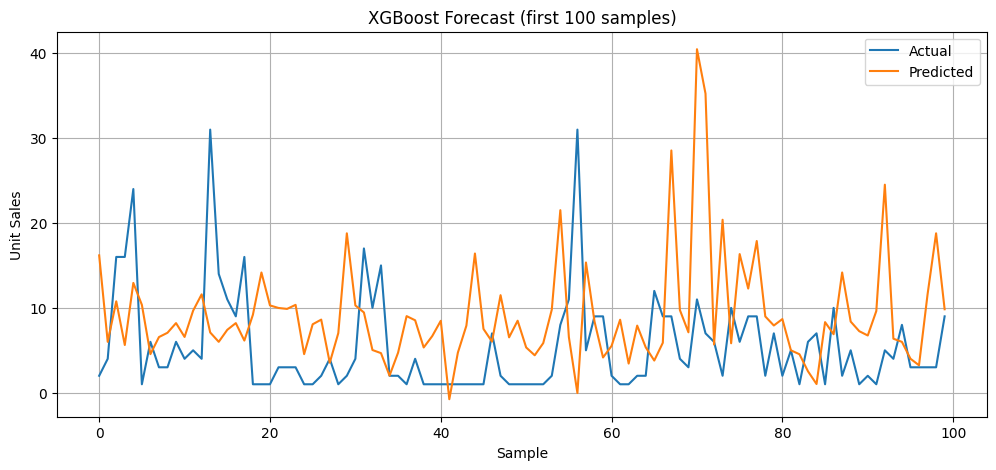

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_xgb.values[:100], label='Actual')
plt.plot(y_pred_xgb[:100], label='Predicted')
plt.title('XGBoost Forecast (first 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Unit Sales')
plt.legend()
plt.grid(True)
plt.show()


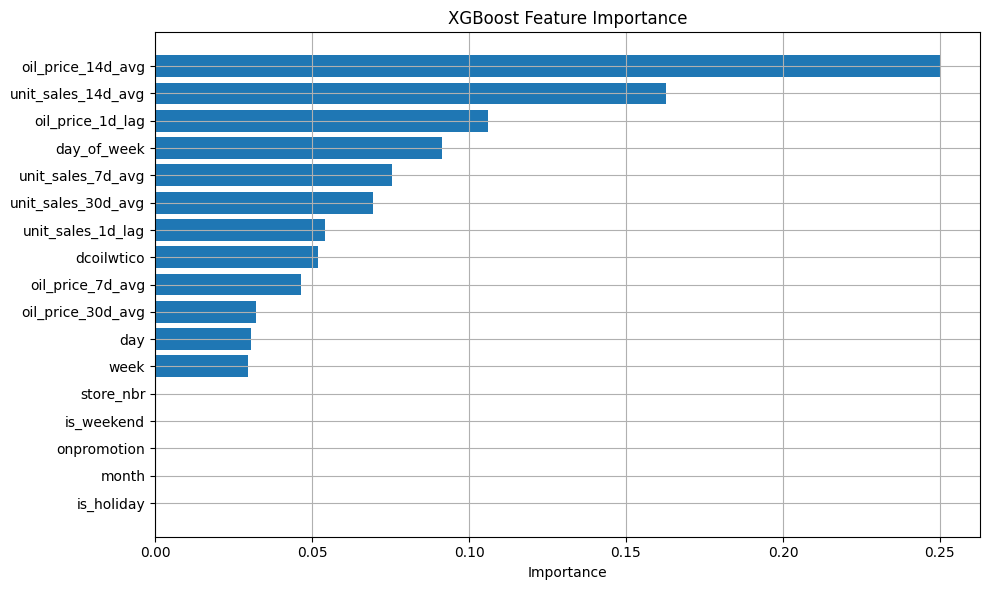

In [18]:
# Feature Importance: XGBoost
importances = model_xgb.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# LSTM Forecast
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [20]:
X_scaled_lstm = scaler_x.fit_transform(xgb_df[features])
y_scaled_lstm = scaler_y.fit_transform(xgb_df['unit_sales'].values.reshape(-1, 1))

window_size = 30

In [21]:
def create_sequences(features, target, window_size):
    X, y = [], []
    for i in range(len(target) - window_size):
        X.append(features[i:i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y).reshape(-1, 1)


In [22]:
X_lstm, y_lstm = create_sequences(X_scaled_lstm, y_scaled_lstm, window_size)
split_idx = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]


In [23]:
model_lstm = Sequential()
model_lstm.add(LSTM(128, return_sequences=True, input_shape=(window_size, X_lstm.shape[2])))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_lstm.fit(X_train_lstm, y_train_lstm,
               validation_data=(X_test_lstm, y_test_lstm),
               epochs=20, batch_size=32,
               callbacks=[early_stop], verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0068 - val_loss: 5.8609e-04
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0040 - val_loss: 4.5474e-04
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0039 - val_loss: 4.4157e-04
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0022 - val_loss: 8.7271e-04
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0038 - val_loss: 4.5643e-04
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0026 - val_loss: 4.8178e-04


In [24]:
y_pred_scaled_lstm = model_lstm.predict(X_test_lstm)
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled_lstm)
y_true_lstm = scaler_y.inverse_transform(y_test_lstm)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


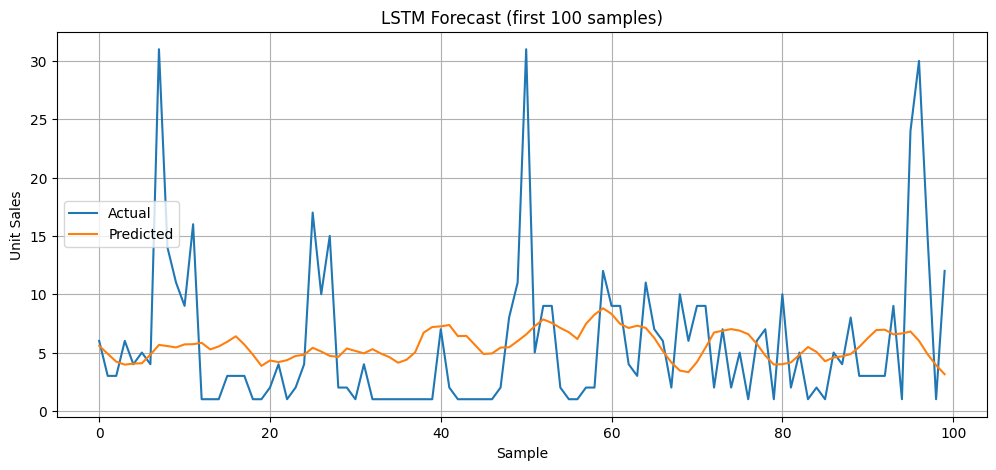

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(y_true_lstm[:100], label='Actual')
plt.plot(y_pred_lstm[:100], label='Predicted')
plt.title('LSTM Forecast (first 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Unit Sales')
plt.legend()
plt.grid(True)
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


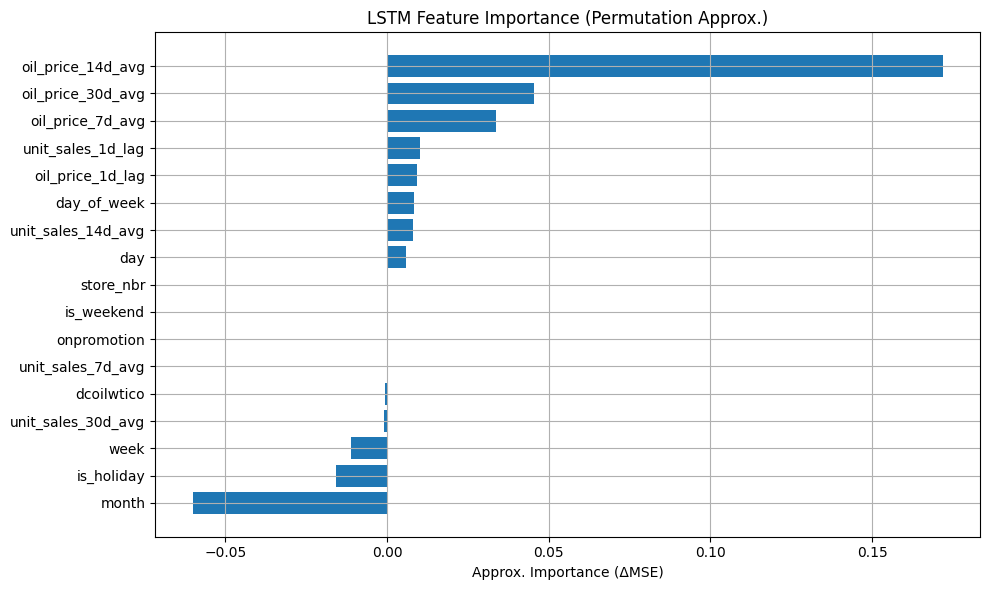

In [26]:
from sklearn.inspection import permutation_importance

def lstm_feature_importance(model, X_test, y_test, scaler_y, feature_names):
    # Flatten to 2D input for permutation (window collapsed)
    X_flat = X_test.reshape((X_test.shape[0], -1))
    y_pred_flat = scaler_y.inverse_transform(model.predict(X_test))
    baseline_mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred_flat)

    importances = []
    for i in range(X_flat.shape[1]):
        X_permuted = X_flat.copy()
        np.random.shuffle(X_permuted[:, i])
        X_permuted_seq = X_permuted.reshape(X_test.shape)
        y_permuted_pred = scaler_y.inverse_transform(model.predict(X_permuted_seq))
        mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_permuted_pred)
        importances.append(mse - baseline_mse)

    avg_importance = np.array(importances).reshape(window_size, -1).mean(axis=0)
    sorted_idx = np.argsort(avg_importance)[::-1]

    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], avg_importance[sorted_idx])
    plt.gca().invert_yaxis()
    plt.title('LSTM Feature Importance (Permutation Approx.)')
    plt.xlabel('Approx. Importance (ΔMSE)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

lstm_feature_importance(model_lstm, X_test_lstm, y_test_lstm, scaler_y, features)

In [27]:
# Hyperparameter Tuning, Comparison & MLflow Logging

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
!pip install mlflow
import mlflow
import mlflow.sklearn
import mlflow.keras
!pip install pyngrok --quiet
from pyngrok import ngrok, conf
import getpass
import subprocess
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 741.4/741.4 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 11.5 MB/s eta 0:00:00


In [28]:
# MLflow Setup
mlflow.set_experiment("Retail Forecast Models")

2025/07/09 08:51:29 INFO mlflow.tracking.fluent: Experiment with name 'Retail Forecast Models' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/266786365688955742', creation_time=1752051089223, experiment_id='266786365688955742', last_update_time=1752051089223, lifecycle_stage='active', name='Retail Forecast Models', tags={}>

In [29]:
# =Define Metrics
def calculate_metrics(y_true, y_pred):
    bias = np.mean(y_pred - y_true)
    mad = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-5))) * 100
    rmad = mad / (np.mean(y_true) + 1e-5)
    return {"Bias": bias, "MAD": mad, "rMAD": rmad, "MAPE": mape, "RMSE": rmse}

In [30]:
# XGBoost Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from xgboost import XGBRegressor
import mlflow.sklearn

# Custom MAPE Scorer (für Random Search)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# XGBoost Parameters
xgb_param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Random Search Setup
xgb_model = XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=50,  # anpassbar je nach Zeitbudget
    scoring=mape_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Start Tuning
random_search.fit(X_train_xgb, y_train_xgb)

# Best Modell & Calculate metrics
best_xgb = random_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_xgb)

# Calculate own Metrics
metrics_xgb = calculate_metrics(y_test_xgb.values, y_pred_xgb)

# Logging in MLflow
mlflow.set_experiment("Retail Forecast Models")

with mlflow.start_run(run_name="Best_XGBoost_MAPE_Tuned"):
    mlflow.set_tag("model", "XGBoost")
    mlflow.log_params(random_search.best_params_)
    for name, val in metrics_xgb.items():
        mlflow.log_metric(name, val)
    mlflow.sklearn.log_model(best_xgb, "model")

# Show Results
print("Beste XGBoost Parameter:", random_search.best_params_)
print("Metriken:", metrics_xgb)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


2025/07/09 08:52:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:52:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Beste XGBoost Parameter: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Metriken: {'Bias': np.float64(2.443816120835984), 'MAD': np.float64(5.7170516576971115), 'rMAD': np.float64(0.8851671390011415), 'MAPE': np.float64(233.11928818369609), 'RMSE': np.float64(6.789104221249606)}


In [31]:
from itertools import product
import random


def build_lstm_model(units_1=128, units_2=64, dropout=0.3, dense=32, optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(LSTM(units_1, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(units_2))
    model.add(Dense(dense, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Define Parameters
param_grid = {
    'units_1': [64, 96, 128, 160],
    'units_2': [32, 64, 80],
    'dropout': [0.2, 0.3, 0.35],
    'batch_size': [16, 32, 48],
    'dense': [16, 32, 48],
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'tanh']
}

# All Combinations
all_combinations = list(product(
    param_grid['units_1'],
    param_grid['units_2'],
    param_grid['dropout'],
    param_grid['batch_size'],
    param_grid['dense'],
    param_grid['optimizer'],
    param_grid['activation']
))

# Random Sample Combination
random.seed(42)  # für Reproduzierbarkeit
sample_size = 50  # z. B. 50 Kombinationen testen
sampled_combinations = random.sample(all_combinations, sample_size)

# MLflow Setup
mlflow.set_experiment("Retail Forecast Models")
best_score = float("inf")

for combo in sampled_combinations:
    params = {
        'units_1': combo[0],
        'units_2': combo[1],
        'dropout': combo[2],
        'batch_size': combo[3],
        'dense': combo[4],
        'optimizer': combo[5],
        'activation': combo[6]
    }

    run_name = f"LSTM_u1_{params['units_1']}_u2_{params['units_2']}_bs_{params['batch_size']}_d_{params['dense']}_{params['activation']}_{params['optimizer']}"

    with mlflow.start_run(run_name=run_name):
        model_lstm_tuned = build_lstm_model(
            units_1=params['units_1'],
            units_2=params['units_2'],
            dropout=params['dropout'],
            dense=params['dense'],
            optimizer=params['optimizer'],
            activation=params['activation']
        )

        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        model_lstm_tuned.fit(
            X_train_lstm, y_train_lstm,
            epochs=20, batch_size=params['batch_size'],
            validation_data=(X_test_lstm, y_test_lstm),
            callbacks=[early_stop], verbose=0
        )

        y_pred_lstm = model_lstm_tuned.predict(X_test_lstm)
        y_pred_real = scaler_y.inverse_transform(y_pred_lstm)
        y_test_real = scaler_y.inverse_transform(y_test_lstm)

        score = np.sqrt(mean_squared_error(y_test_real, y_pred_real))

        if score < best_score:
            best_score = score
            best_lstm_model = model_lstm_tuned
            best_lstm_params = params
            best_lstm_pred = y_pred_real
            best_lstm_true = y_test_real

        metrics = calculate_metrics(y_test_real.flatten(), y_pred_real.flatten())

        mlflow.set_tag("model", "LSTM")
        mlflow.log_params(params)
        for name, value in metrics.items():
            mlflow.log_metric(name, value)

        mlflow.keras.log_model(model_lstm_tuned, "model")

# best Parameters
metrics_lstm = calculate_metrics(best_lstm_true.flatten(), best_lstm_pred.flatten())
print("Beste LSTM Parameter:", best_lstm_params)
print("Metriken:", metrics_lstm)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


2025/07/09 08:52:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:52:29 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 08:52:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


2025/07/09 08:52:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:52:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 08:52:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


2025/07/09 08:53:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:53:19 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 08:53:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


2025/07/09 08:53:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:53:40 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 08:53:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


2025/07/09 08:54:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:54:01 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 08:54:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


2025/07/09 08:54:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:54:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 08:54:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


2025/07/09 08:54:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:54:53 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 08:55:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


2025/07/09 08:55:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:55:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 08:55:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


2025/07/09 08:55:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:55:51 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 08:55:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


2025/07/09 08:56:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:56:24 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 08:56:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


2025/07/09 08:56:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:56:54 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 08:57:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


2025/07/09 08:57:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:57:13 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 08:57:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


2025/07/09 08:57:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:57:29 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 08:57:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


2025/07/09 08:57:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:57:59 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 08:58:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


2025/07/09 08:58:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:58:20 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 08:58:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


2025/07/09 08:58:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:58:50 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 08:58:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


2025/07/09 08:59:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:59:21 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 08:59:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


2025/07/09 08:59:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 08:59:52 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:00:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


2025/07/09 09:00:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:00:12 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:00:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


2025/07/09 09:00:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:00:38 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:00:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


2025/07/09 09:00:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:00:57 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:01:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


2025/07/09 09:01:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:01:29 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:01:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step


2025/07/09 09:01:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:01:53 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:02:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


2025/07/09 09:02:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:02:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:02:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


2025/07/09 09:03:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:03:11 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:03:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


2025/07/09 09:03:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:03:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:03:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


2025/07/09 09:03:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:03:55 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:04:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


2025/07/09 09:04:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:04:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:04:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


2025/07/09 09:05:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:05:07 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:05:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


2025/07/09 09:05:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:05:42 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:05:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


2025/07/09 09:06:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:06:03 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:06:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


2025/07/09 09:06:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:06:38 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:06:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


2025/07/09 09:07:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:07:13 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:07:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


2025/07/09 09:07:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:07:39 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:07:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


2025/07/09 09:08:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:08:16 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:08:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


2025/07/09 09:08:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:08:37 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:08:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


2025/07/09 09:09:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:09:11 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:09:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


2025/07/09 09:09:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:09:48 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:09:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 308ms/step


2025/07/09 09:10:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:10:20 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:10:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


2025/07/09 09:11:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:11:00 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:11:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


2025/07/09 09:11:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:11:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:11:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


2025/07/09 09:11:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:11:54 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:12:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


2025/07/09 09:12:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:12:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:12:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


2025/07/09 09:12:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:12:58 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:13:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


2025/07/09 09:13:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:13:27 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:13:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


2025/07/09 09:13:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:13:56 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:14:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


2025/07/09 09:14:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:14:31 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:14:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


2025/07/09 09:14:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:14:58 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:15:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


2025/07/09 09:15:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:15:24 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:15:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


2025/07/09 09:16:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:16:03 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:16:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Beste LSTM Parameter: {'units_1': 96, 'units_2': 32, 'dropout': 0.2, 'batch_size': 16, 'dense': 16, 'optimizer': 'rmsprop', 'activation': 'relu'}
Metriken: {'Bias': np.float64(-0.5193915679076008), 'MAD': np.float64(4.378435295318889), 'rMAD': np.float64(0.6859324196946297), 'MAPE': np.float64(140.14494508958944), 'RMSE': np.float64(6.145900567716986)}


In [32]:
with mlflow.start_run(run_name="Best_LSTM"):
    mlflow.set_tag("model", "LSTM")
    mlflow.log_params(best_lstm_params)
    for name, val in metrics_lstm.items():
        mlflow.log_metric(name, val)
    mlflow.keras.log_model(best_lstm_model, "model")

2025/07/09 09:16:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 09:16:11 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/09 09:16:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [33]:
import time
subprocess.Popen(["mlflow", "ui", "--host", "0.0.0.0", "--port", "5000"])
time.sleep(3)

In [34]:
# Start MLflow UI via ngrok
ngrok.set_auth_token("2xbQU3h5ww2QAxLYUj2lp9GvUpz_3kbiUedF3nrXwxKYn3ZyM")
mlflow_ui = ngrok.connect(5000)
print(f"MLflow UI läuft unter: {mlflow_ui}")

MLflow UI läuft unter: NgrokTunnel: "https://40412feb1c70.ngrok-free.app" -> "http://localhost:5000"


In [35]:
# Optimated LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(128, return_sequences=True, input_shape=(window_size, len(features))))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(48, activation='relu'))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mse')

# Callback: Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train Modell
history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=30,
    batch_size=32,          # kleiner für bessere Generalisierung
    callbacks=[early_stop],
    shuffle=False,          # Zeitreihen wichtig!
    verbose=1
)


Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0044 - val_loss: 8.5118e-04
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0036 - val_loss: 4.4019e-04
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0035 - val_loss: 5.7130e-04
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0035 - val_loss: 8.2731e-04
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0036 - val_loss: 4.5199e-04


In [36]:
# Prediction LSTM
y_pred_scaled_lstm = model_lstm.predict(X_test_lstm)

# Transform original Scale
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled_lstm)
y_true_lstm = scaler_y.inverse_transform(y_test_lstm)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


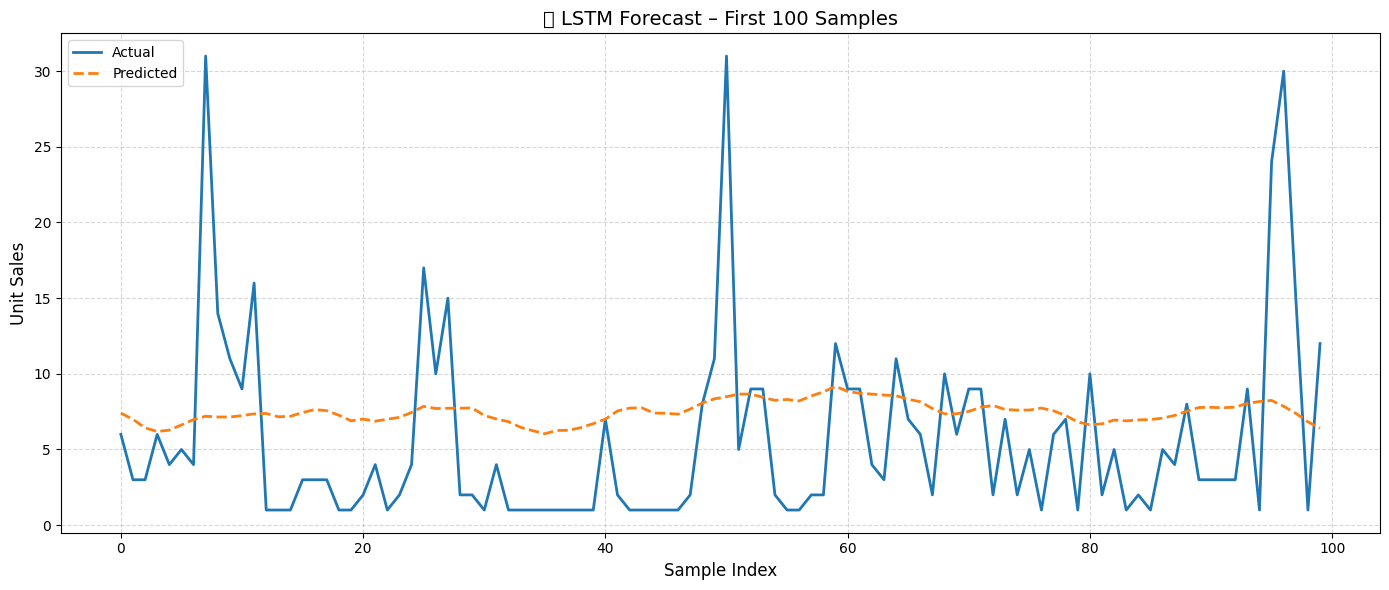

In [37]:
# Forecast Plot
plt.figure(figsize=(14, 6))
plt.plot(y_true_lstm[:100], label='Actual', linewidth=2)
plt.plot(y_pred_lstm[:100], label='Predicted', linestyle='--', linewidth=2)
plt.title('🔮 LSTM Forecast – First 100 Samples', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Unit Sales', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [38]:
# More Feature-Spikes
xgb_df['unit_sales_ratio_1_30'] = xgb_df['unit_sales_1d_lag'] / (xgb_df['unit_sales_30d_avg'] + 1)
xgb_df['unit_sales_ratio_7_30'] = xgb_df['unit_sales_7d_avg'] / (xgb_df['unit_sales_30d_avg'] + 1)
xgb_df['promo_spike'] = (xgb_df['onpromotion'] > 0) & (xgb_df['unit_sales_1d_lag'] > 10)


In [39]:
# Optimized XGBoost Modell
model_xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=2.0,
    random_state=42
)


In [40]:
# Split
train_size = int(len(X) * 0.8)
X_train_xgb, X_test_xgb = X.iloc[:train_size], X.iloc[train_size:]
y_train_xgb, y_test_xgb = y.iloc[:train_size], y.iloc[train_size:]

# Train
model_xgb.fit(X_train_xgb, y_train_xgb)

# Prediction
y_pred_xgb = model_xgb.predict(X_test_xgb)

# Calculate Metrics
metrics_xgb = calculate_metrics(y_test_xgb.values, y_pred_xgb)

print("Metriken für verbessertes XGBoost-Modell:")
for name, value in metrics_xgb.items():
    print(f"{name}: {value:.4f}")

Metriken für verbessertes XGBoost-Modell:
Bias: 2.6210
MAD: 6.9984
rMAD: 1.0836
MAPE: 242.2525
RMSE: 10.0892


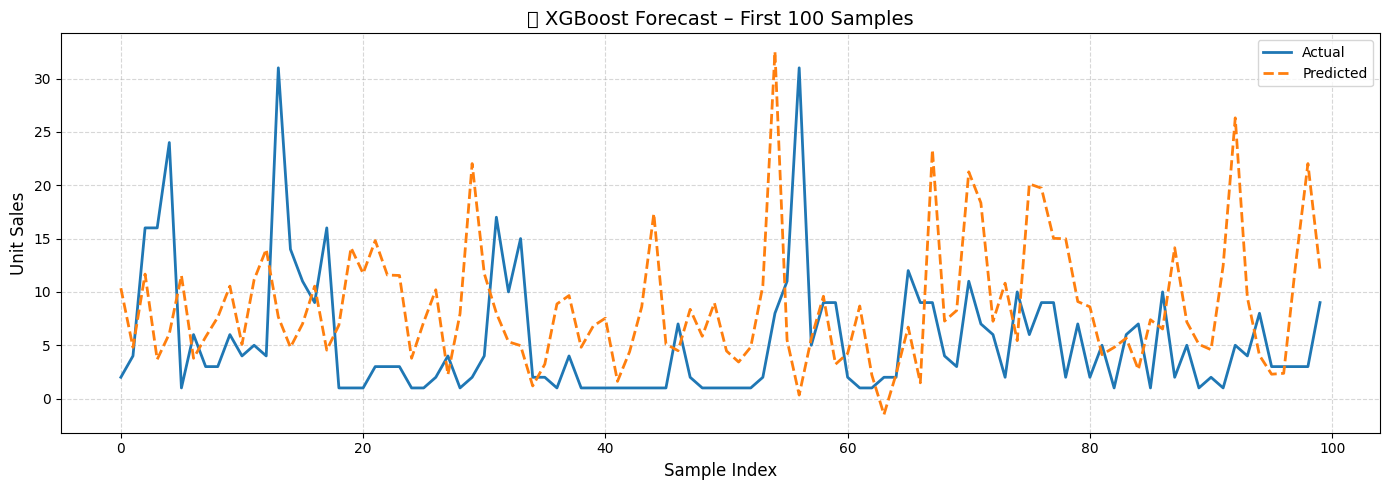

In [41]:
# Forecast-Plot
plt.figure(figsize=(14, 5))
plt.plot(y_test_xgb.values[:100], label='Actual', linewidth=2)
plt.plot(y_pred_xgb[:100], label='Predicted', linestyle='--', linewidth=2)
plt.title("📈 XGBoost Forecast – First 100 Samples", fontsize=14)
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Unit Sales", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

📊 Metriken für Hybridmodell mit Spike-Verstärkung:
Bias: 1.8705
MAD: 5.7370
rMAD: 0.8794
MAPE: 212.3724
RMSE: 7.2349


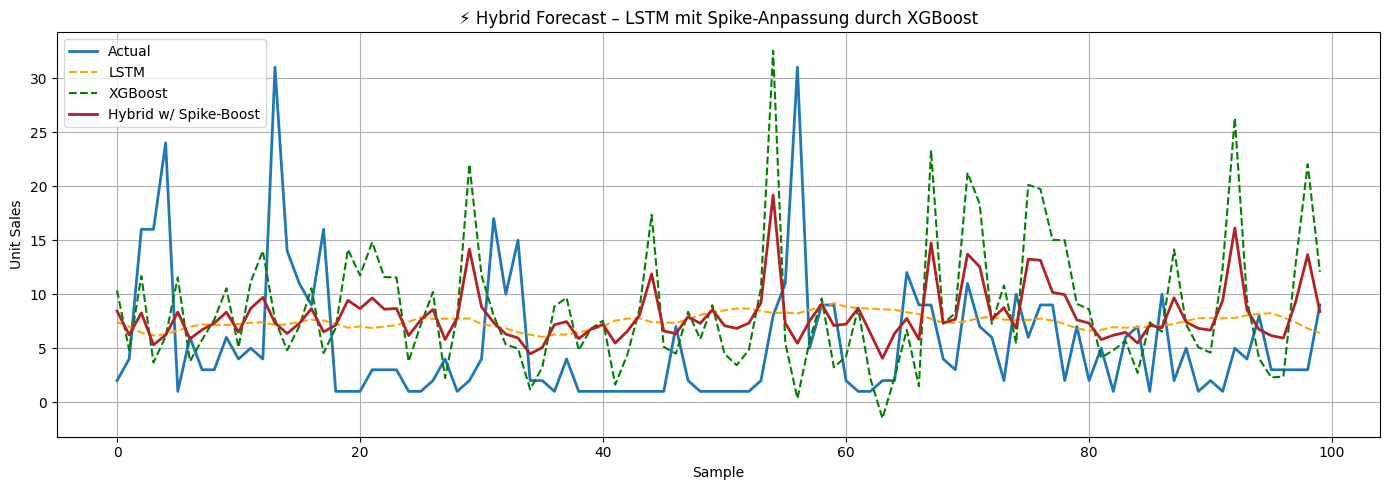

In [42]:
# Set Length of Prediction
min_len = min(len(y_pred_lstm), len(y_pred_xgb), len(y_test_xgb))

y_pred_lstm_aligned = y_pred_lstm[:min_len].flatten()
y_pred_xgb_aligned = y_pred_xgb[:min_len].flatten()
y_true_hybrid = y_test_xgb.values[:min_len]

# Optimized Hybrid-Strategy
base_alpha = 0.65
threshold = 8
boost_strength = 0.1

hybrid_preds = []
for i in range(min_len):
    delta = abs(y_pred_xgb_aligned[i] - y_pred_lstm_aligned[i])
    if delta > threshold:
        alpha = base_alpha - boost_strength
    else:
        alpha = base_alpha
    hybrid = alpha * y_pred_lstm_aligned[i] + (1 - alpha) * y_pred_xgb_aligned[i]
    hybrid_preds.append(hybrid)

y_pred_hybrid = np.array(hybrid_preds)

# Calculate Metrics
metrics_hybrid = calculate_metrics(y_true_hybrid, y_pred_hybrid)
print("📊 Metriken für Hybridmodell mit Spike-Verstärkung:")
for name, value in metrics_hybrid.items():
    print(f"{name}: {value:.4f}")

# Vis
plt.figure(figsize=(14, 5))
plt.plot(y_true_hybrid[:100], label='Actual', linewidth=2)
plt.plot(y_pred_lstm_aligned[:100], label='LSTM', linestyle='--', color='orange')
plt.plot(y_pred_xgb_aligned[:100], label='XGBoost', linestyle='--', color='green')
plt.plot(y_pred_hybrid[:100], label='Hybrid w/ Spike-Boost', color='firebrick', linewidth=2)
plt.title("⚡ Hybrid Forecast – LSTM mit Spike-Anpassung durch XGBoost")
plt.xlabel("Sample")
plt.ylabel("Unit Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
# create a directory in your google drive to store a model
# NOTE: your google drive must be mounted before!
!mkdir /content/drive/MyDrive/models/

mkdir: cannot create directory ‘/content/drive/MyDrive/models/’: File exists


In [44]:
import pickle
import os

# Saving Path
path_for_saving = '/content/drive/MyDrive/models/hybrid_spikeboost_model.pkl'

# Save important Parts
hybrid_model_dict = {
    "best_params": best_params,
    "best_metrics": best_metrics,
    "predictions": best_pred,
    "y_true": y_true
}

# Save Modell
os.makedirs(os.path.dirname(path_for_saving), exist_ok=True)
with open(path_for_saving, 'wb') as f:
    pickle.dump(hybrid_model_dict, f)

print(f"✅ Hybridmodell mit Spike-Boost gespeichert unter:\n{path_for_saving}")


NameError: name 'best_params' is not defined

In [ ]:

xgb_model_path = '/content/drive/MyDrive/models/model_xgb_best.pkl'


os.makedirs(os.path.dirname(xgb_model_path), exist_ok=True)


with open(xgb_model_path, 'wb') as f:
    pickle.dump(model_xgb, f)

print(f"✅ XGBoost-Modell gespeichert unter:\n{xgb_model_path}")

In [ ]:
from tensorflow.keras.models import load_model
import os

# Speicherpfad für LSTM-Modell
lstm_model_path = '/content/drive/MyDrive/models/model_lstm_best.h5'

# Ordner anlegen, falls nicht vorhanden
os.makedirs(os.path.dirname(lstm_model_path), exist_ok=True)

# Modell speichern
model_lstm.save(lstm_model_path)

print(f"✅ LSTM-Modell gespeichert unter:\n{lstm_model_path}")


In [49]:
import joblib
import os
import pickle
from tensorflow.keras.models import load_model

joblib.dump(scaler_x, '/content/drive/MyDrive/models/scaler_x_lstm.pkl')
joblib.dump(scaler_y, '/content/drive/MyDrive/models/scaler_y_lstm.pkl')


['/content/drive/MyDrive/models/scaler_y_lstm.pkl']